In [184]:
# https://www.youtube.com/watch?v=VMj-3S1tku0

import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

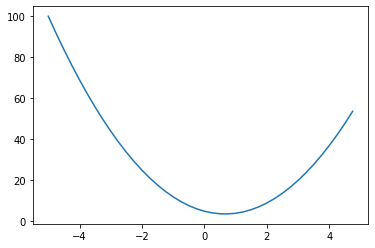

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [16]:
h = 0.0000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [18]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [21]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [169]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __radd__(self, other):
       return self + other
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1

        for node in reversed(topo):
            node._backward()


In [161]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

1 + a

Value(data=3.0)

In [68]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if(v not in nodes):
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


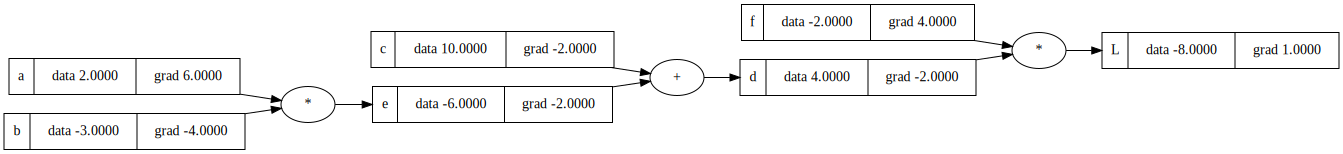

In [83]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0
L.grad = 1.0
draw_dot(L)

In [82]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h)
    

In [80]:
lol()

3.9999999999995595


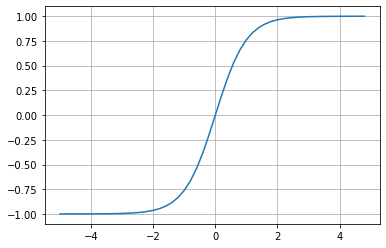

In [85]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [162]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# neuron bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label='o'
o.backward()

In [115]:
o.grad = 1.0
n.grad = o.grad * (1 - o.data**2)
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

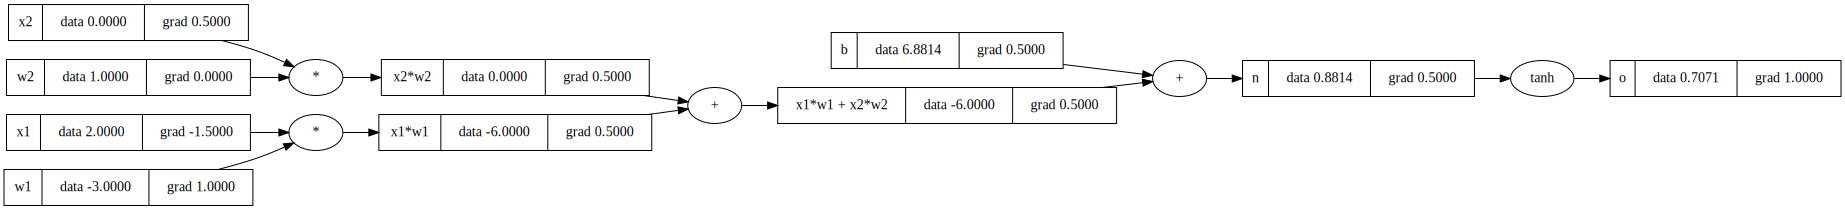

In [163]:
draw_dot(o)

In [128]:
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


In [141]:
o.backward()

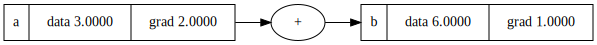

In [147]:
# bug 1

a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

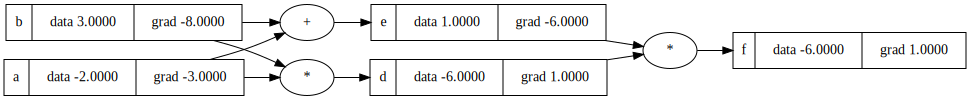

In [148]:
# bug 2 (not handling the multivariable case of the chain rule, 1:25:22)
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a+ b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

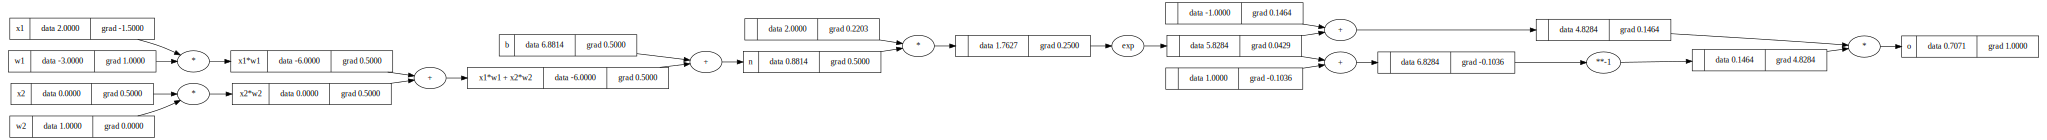

In [171]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# neuron bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1)/(e + 1)

o.label='o'
o.backward()
draw_dot(o)

In [176]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [205]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts # note: [2] + [3] = [2, 3] in python
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [236]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [237]:
n.parameters()

[Value(data=-0.5331219112735779),
 Value(data=0.37648291983241555),
 Value(data=-0.8767445787302419),
 Value(data=-0.6761119185281879),
 Value(data=-0.9437038468085572),
 Value(data=-0.21753768567478726),
 Value(data=0.6109248568577661),
 Value(data=-0.7228928603338096),
 Value(data=-0.36810959281823097),
 Value(data=-0.7314205206664175),
 Value(data=-0.7818691136659928),
 Value(data=0.4129336885084016),
 Value(data=0.9634560628240794),
 Value(data=-0.3820424681380392),
 Value(data=-0.8106180415865814),
 Value(data=-0.41931490613528943),
 Value(data=0.4327263657822171),
 Value(data=0.11047796663562348),
 Value(data=0.3553579282362085),
 Value(data=-0.27160336112574646),
 Value(data=0.8034369041491605),
 Value(data=0.42844026328710805),
 Value(data=-0.980927347707796),
 Value(data=-0.1483295842862835),
 Value(data=-0.6668778120690437),
 Value(data=0.11611724368158427),
 Value(data=-0.0982653931716051),
 Value(data=-0.5805357763465431),
 Value(data=0.20172756159723115),
 Value(data=0.027

In [238]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [242]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0;
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    print(k, loss.data)

0 0.0376861616961785
1 0.03698034503904312
2 0.03629968057540099
3 0.035642864998682404
4 0.03500868282287368
5 0.03439599914733914
6 0.033803753122476014
7 0.03323095203851431
8 0.032676665969434325
9 0.03214002291231262
10 0.03162020436960744
11 0.031116441328144177
12 0.030628010593977503
13 0.030154231447031048
14 0.02969446258352791
15 0.029248099317820575
16 0.02881457101837976
17 0.02839333875546196
18 0.0279838931404024
19 0.02758575233861809


In [243]:
ypred

[Value(data=0.9194801721877874),
 Value(data=-0.9598859731814997),
 Value(data=-0.8765985216733503),
 Value(data=0.9346911210713905)]

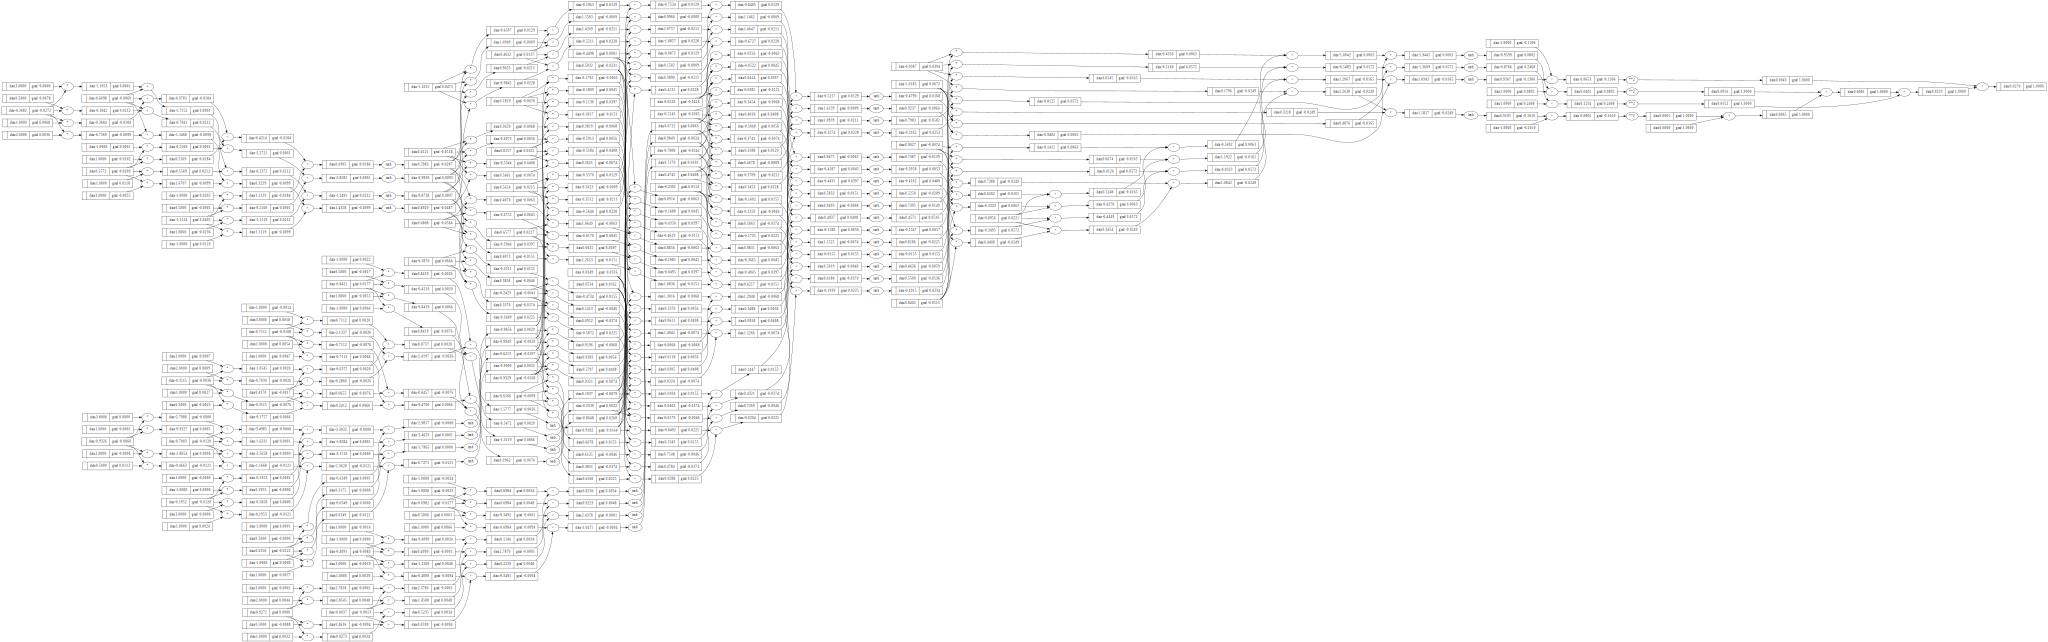

In [244]:
draw_dot(loss)